In [108]:
import pandas as pd
from sqlalchemy import create_engine
import gmaps
import keyring
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pymongo

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import pymongo
# import datetime
# from flask import Flask
# import pymysql
# from sqlalchemy import create_engine
# import json

In [162]:
#defines path for csv/tsv's
# path_1 = "Resources/county_market_tracker.tsv000"
path_2 = "Resources/state_market_tracker.tsv000"
# path_3 = "Resources/us_national_market_tracker.tsv000"
path_4 = "Resources/data_cleaned_2021.csv"

In [163]:
#reads in data to pandas dataframes
# county_df = pd.read_csv(path_1,sep='\t')
state_df = pd.read_csv(path_2,sep='\t')
# national_df = pd.read_csv(path_3,sep='\t')
salary_df = pd.read_csv(path_4)

In [189]:
#prints out heads of dataframes being used
state_df.head()

,End Date,State,State Code,Median Sale Price,Median Paid Per Sqft,Number of Listings
0,2019-10-31,Oklahoma,OK,162200,77.0,81.0
1,2021-07-31,Vermont,VT,317900,177.0,2760.0
4,2019-12-31,Missouri,MO,152000,135.0,487.0
5,2019-07-31,New Mexico,NM,385500,218.0,1034.0
9,2020-03-31,Ohio,OH,156100,111.0,2535.0


In [190]:
salary_df.head()

,Rating,Lower Salary,Upper Salary,Avg Salary(K),Job Location,Job Title,Seniority by Title
0,3.8,53,91,72.0,NM,data scientist,na
1,3.4,63,112,87.5,MD,data scientist,na
2,4.8,80,90,85.0,FL,data scientist,na
3,3.8,56,97,76.5,WA,data scientist,na
4,2.9,86,143,114.5,NY,data scientist,na


In [166]:
#prints out list of columns for salary_df
for col in salary_df.columns:
    print(col)

index
Job Title
Salary Estimate
Job Description
Rating
Company Name
Location
Headquarters
Size
Founded
Type of ownership
Industry
Sector
Revenue
Competitors
Hourly
Employer provided
Lower Salary
Upper Salary
Avg Salary(K)
company_txt
Job Location
Age
Python
spark
aws
excel
sql
sas
keras
pytorch
scikit
tensor
hadoop
tableau
bi
flink
mongo
google_an
job_title_sim
seniority_by_title
Degree


In [167]:
#Grabs columns we need from salary_df
salary_df = salary_df[['Rating','Lower Salary','Upper Salary','Avg Salary(K)','Job Location','job_title_sim','seniority_by_title']]

In [168]:
#Renames columns in salary_df
salary_df = salary_df.rename(columns={'job_title_sim':'Job Title','seniority_by_title':'Seniority by Title'})

In [169]:
#drops columns not needed in state_df
state_df = state_df.drop(columns={
                         'period_begin',
                         'period_duration',
                         'region_type',
                         'region_type_id',
                         'table_id',
                         'is_seasonally_adjusted',
                         'region',
                         'city',
                         'property_type',
                         'property_type_id',
                         'median_sale_price_mom',
                         'median_sale_price_yoy',
                         'median_list_price',
                         'median_list_price_mom',
                         'median_list_price_yoy',
                         'median_ppsf_mom',
                         'median_ppsf_yoy',
                         'median_list_ppsf',
                         'median_list_ppsf_mom',
                         'median_list_ppsf_yoy',
                         'homes_sold',
                         'homes_sold_mom',
                         'homes_sold_yoy',
                         'pending_sales',
                         'pending_sales_mom',
                         'pending_sales_yoy',
                         'new_listings',
                         'new_listings_mom',
                         'new_listings_yoy',
                         # inventory?
                         'inventory_mom',
                         'inventory_yoy',
                         'months_of_supply',
                         'months_of_supply_mom',
                         'months_of_supply_yoy',
                         'median_dom',
                         'median_dom_mom',
                         'median_dom_yoy',
                         'avg_sale_to_list',
                         'avg_sale_to_list_mom',
                         'avg_sale_to_list_yoy',
                         'sold_above_list',
                         'sold_above_list_mom',
                         'sold_above_list_yoy',
                         'price_drops',
                         'price_drops_mom',
                         'price_drops_yoy',
                         'off_market_in_two_weeks',
                         'off_market_in_two_weeks_mom',
                         'off_market_in_two_weeks_yoy',
                         'parent_metro_region',
                         'parent_metro_region_metro_code',
                         'last_updated'})

In [170]:
#Rename columns of state_df
state_df = state_df.rename(columns={'period_end':'End Date','state':'State','median_sale_price':'Median Sale Price','median_ppsf':'Median Paid Per Sqft','inventory':'Number of Listings','state_code':'State Code'})

In [171]:
#Counts values for each positon
salary_df['Job Title'].value_counts()

data scientist                    313
other scientist                   143
data engineer                     119
analyst                           101
machine learning engineer          22
Data scientist project manager     16
na                                 10
data analitics                      8
data modeler                        5
director                            5
Name: Job Title, dtype: int64

In [172]:
state_df['End Date'] = pd.to_datetime(state_df['End Date'], format='%Y-%m-%d')
state_df['State Code'] = state_df['State Code'].astype('string')
state_df.dtypes

End Date                datetime64[ns]
State                           object
State Code                      string
Median Sale Price                int64
Median Paid Per Sqft           float64
Number of Listings             float64
dtype: object

In [173]:
#Drops rows 2018 and older
state_df = state_df[state_df['End Date'].dt.year > 2018]

In [174]:
#Converting types to strings
salary_df['Job Location'] = salary_df['Job Location'].astype('string')
salary_df['Job Title'] = salary_df['Job Title'].astype('string')
salary_df['Seniority by Title'] = salary_df['Seniority by Title'].astype('string')
salary_df.dtypes

Rating                float64
Lower Salary            int64
Upper Salary            int64
Avg Salary(K)         float64
Job Location           string
Job Title              string
Seniority by Title     string
dtype: object

In [175]:
#Drop senior and junior titles
salary_df = salary_df[salary_df['Seniority by Title'] != "sr"]
salary_df = salary_df[salary_df['Seniority by Title'] != "jr"]

In [188]:
# state_df['State'].value_counts()
state_df['State'].unique()

array(['Oklahoma', 'Vermont', 'Missouri', 'New Mexico', 'Ohio', 'Georgia',
       'Massachusetts', 'Minnesota', 'Pennsylvania', 'Columbia',
       'Kentucky', 'Florida', 'New Hampshire', 'Texas', 'Washington',
       'Nevada', 'Kansas', 'Wisconsin', 'New York', 'Colorado',
       'Nebraska', 'California', 'Iowa', 'Virginia', 'Hawaii',
       'Louisiana', 'New Jersey', 'North Carolina', 'Illinois', 'Alaska',
       'Idaho', 'Maine', 'Utah', 'Maryland', 'Arkansas', 'Connecticut',
       'Indiana', 'Mississippi', 'Tennessee', 'Oregon', 'Rhode Island',
       'Alabama', 'Arizona', 'Michigan', 'South Carolina', 'Delaware',
       'West Virginia'], dtype=object)

In [ ]:

# What is the highest differential between salary and price?


In [35]:
job_locations = salary_df['Location'].value_counts()

In [58]:
job_locations_reduced = job_locations[job_locations != 1]

In [59]:
job_locations_reduced = job_locations_reduced[job_locations_reduced != 2]

In [62]:
job_locations_reduced = job_locations_reduced[job_locations_reduced != 3]

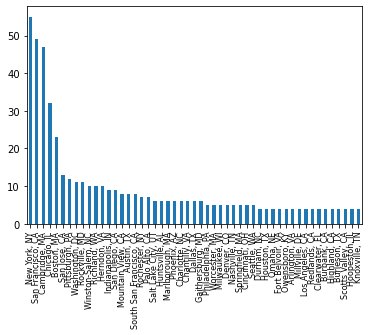

In [64]:
job_locations_reduced.plot(kind='bar')
plt.xticks(fontsize=8)
plt.show()

In [26]:
# g_key = keyring.get_password('google_api','kevinflores96@gmail.com')

In [29]:
gmaps.configure(api_key=g_key)

In [191]:
# g_key

In [ ]:
# locations = data[['Lat','Lng']]
# humidity = data['Humidity']
# fig = gmaps.figure()
# heat_layer = gmaps.heatmap_layer(locations, weights=humidity,
#                                  dissipating=False,max_intensity=100,
#                                  point_radius=2.5)
# fig.add_layer(heat_layer)
# fig